In [40]:
import os

import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

import regionmask

import pandas as pd
import geopandas as gpd
import dask_geopandas as dgpd
from shapely.geometry import Point
from dask import dataframe as dd

import polars as pl
import gc 
import pyarrow as pa

%matplotlib inline

In [41]:
# ds = xr.open_dataset('/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/power_nasa_data.nc')
ds = xr.open_dataset('/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/power_nasa_data.nc')


In [42]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:            (time: 8498, lat: 48, lon: 60)
Coordinates:
  * time               (time) datetime64[ns] 68kB 2001-01-01 ... 2024-04-07
  * lat                (lat) float64 384B -4.5 -4.0 -3.5 -3.0 ... 18.0 18.5 19.0
  * lon                (lon) float64 480B 22.5 23.0 23.5 24.0 ... 51.0 51.5 52.0
Data variables: (12/14)
    PRECTOTCORR        (time, lat, lon) float64 196MB ...
    EVPTRNS            (time, lat, lon) float64 196MB ...
    T2M                (time, lat, lon) float64 196MB ...
    TS                 (time, lat, lon) float64 196MB ...
    PS                 (time, lat, lon) float64 196MB ...
    WS2M               (time, lat, lon) float64 196MB ...
    ...                 ...
    RH2M               (time, lat, lon) float64 196MB ...
    GWETROOT           (time, lat, lon) float64 196MB ...
    GWETPROF           (time, lat, lon) float64 196MB ...
    GWETTOP            (time, lat, lon) float64 196MB ...
    CLOUD_AMT          (time, lat, lon) float64 196MB ...
    ALLSKY_SFC_SW_DWN  (time, lat, lon) float64 196MB ...

In [43]:
df_pandas = ds.to_dataframe().reset_index()

# Close the dataset
ds.close()


In [44]:
df_pandas.head()

,time,lat,lon,PRECTOTCORR,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,CLOUD_AMT,ALLSKY_SFC_SW_DWN
0,2001-01-01,-4.5,22.5,0.000043,107.140625,296.804688,296.453125,95028.0000,0.234375,0.921875,0.017090,88.6875,0.523438,0.531250,0.609375,96.773438,70.937500
1,2001-01-01,-4.5,23.0,0.000069,98.840625,296.879687,296.621875,95095.4500,0.234375,0.878125,0.017334,89.4875,0.604688,0.612500,0.678125,97.851562,76.527344
2,2001-01-01,-4.5,23.5,0.000068,98.514062,296.809375,296.509375,94904.9000,0.210938,0.853125,0.017249,89.3125,0.657813,0.646875,0.718750,98.929688,82.117188
3,2001-01-01,-4.5,24.0,0.000054,92.179688,296.831250,296.606250,94647.9750,0.276562,1.003125,0.017078,88.4625,0.685937,0.668750,0.734375,99.144531,89.527344
4,2001-01-01,-4.5,24.5,0.000039,83.300000,297.003125,296.982813,94506.4625,0.523438,1.365625,0.016907,87.0250,0.706250,0.706250,0.739062,99.359375,96.937500


In [45]:
# Convert the Pandas DataFrame to a Polars DataFrame
df_polars = pl.from_pandas(df_pandas)


In [46]:
del df_pandas
gc.collect()

27

In [47]:
df_polars

time,lat,lon,PRECTOTCORR,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,CLOUD_AMT,ALLSKY_SFC_SW_DWN
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2001-01-01 00:00:00,-4.5,22.5,0.000043,107.140625,296.804688,296.453125,95028.0,0.234375,0.921875,0.01709,88.6875,0.5234375,0.53125,0.609375,96.773438,70.9375
2001-01-01 00:00:00,-4.5,23.0,0.000069,98.840625,296.879687,296.621875,95095.45,0.234375,0.878125,0.017334,89.4875,0.6046875,0.6125,0.678125,97.851562,76.527344
2001-01-01 00:00:00,-4.5,23.5,0.000068,98.514062,296.809375,296.509375,94904.9,0.2109375,0.853125,0.017249,89.3125,0.6578125,0.646875,0.71875,98.929688,82.117188
2001-01-01 00:00:00,-4.5,24.0,0.000054,92.179688,296.83125,296.60625,94647.975,0.2765625,1.003125,0.017078,88.4625,0.6859375,0.66875,0.734375,99.144531,89.527344
2001-01-01 00:00:00,-4.5,24.5,0.000039,83.3,297.003125,296.982813,94506.4625,0.5234375,1.365625,0.016907,87.025,0.70625,0.70625,0.7390625,99.359375,96.9375
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-04-07 00:00:00,19.0,50.0,0.0,null,303.75,305.398438,97302.5,2.9921875,4.0546875,0.007019,26.25,null,null,null,null,null
2024-04-07 00:00:00,19.0,50.5,0.0,null,303.78125,305.579687,97441.2,2.7171875,3.7296875,0.006335,23.65,null,null,null,null,null
2024-04-07 00:00:00,19.0,51.0,0.0,null,303.760938,305.732813,97548.6625,2.3953125,3.3765625,0.005652,21.0875,null,null,null,null,null


In [48]:
def calculate_missing_percentages(df: pl.DataFrame) -> pl.DataFrame:
    """
    Calculates the percentage of missing values in each column of a Polars DataFrame.

    Parameters:
    - df (pl.DataFrame): The input DataFrame with potentially missing values.

    Returns:
    - pl.DataFrame: A DataFrame with one row showing the percentage of missing values for each column.

    Example of usage:
    missing_percentages = calculate_missing_percentages(polars_df)
    print(missing_percentages)
    """
    total_rows = df.height  # Access the number of rows in the DataFrame
    missing_counts = df.select([pl.col(column).is_null().sum().alias(column) for column in df.columns])
    missing_percentage = missing_counts / total_rows * 100
    
    return missing_percentage

In [49]:
missing_percentages = calculate_missing_percentages(df_polars)
missing_percentages

time,lat,lon,PRECTOTCORR,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,CLOUD_AMT,ALLSKY_SFC_SW_DWN
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,18.578996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.578996,18.578996,1.141445,1.141445,1.141445


In [50]:
# Drop rows where any cell has NaN
clean_df = df_polars.drop_nulls()

In [51]:
clean_df

time,lat,lon,PRECTOTCORR,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,CLOUD_AMT,ALLSKY_SFC_SW_DWN
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2001-01-01 00:00:00,-4.5,22.5,0.000043,107.140625,296.804688,296.453125,95028.0,0.234375,0.921875,0.01709,88.6875,0.5234375,0.53125,0.609375,96.773438,70.9375
2001-01-01 00:00:00,-4.5,23.0,0.000069,98.840625,296.879687,296.621875,95095.45,0.234375,0.878125,0.017334,89.4875,0.6046875,0.6125,0.678125,97.851562,76.527344
2001-01-01 00:00:00,-4.5,23.5,0.000068,98.514062,296.809375,296.509375,94904.9,0.2109375,0.853125,0.017249,89.3125,0.6578125,0.646875,0.71875,98.929688,82.117188
2001-01-01 00:00:00,-4.5,24.0,0.000054,92.179688,296.83125,296.60625,94647.975,0.2765625,1.003125,0.017078,88.4625,0.6859375,0.66875,0.734375,99.144531,89.527344
2001-01-01 00:00:00,-4.5,24.5,0.000039,83.3,297.003125,296.982813,94506.4625,0.5234375,1.365625,0.016907,87.025,0.70625,0.70625,0.7390625,99.359375,96.9375
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-01-01 00:00:00,19.0,50.0,0.0,0.21875,294.921875,295.84375,98189.5625,2.2890625,3.34375,0.007019,43.75,0.1015625,0.109375,0.078125,7.087891,204.916016
2024-01-01 00:00:00,19.0,50.5,0.0,0.34375,295.078125,296.03125,98313.5625,2.1140625,3.13125,0.007214,44.6,0.0953125,0.096875,0.078125,7.734375,199.835938
2024-01-01 00:00:00,19.0,51.0,0.0,0.628125,295.13125,296.096875,98409.3625,1.98125,2.9984375,0.007483,46.425,0.103125,0.103125,0.0875,8.5859375,200.849609


In [52]:
missing_percentages = calculate_missing_percentages(clean_df)
missing_percentages

time,lat,lon,PRECTOTCORR,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,CLOUD_AMT,ALLSKY_SFC_SW_DWN
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap

# def visualize_regions_polars(df):
#     """
#     Visualizes geographic regions directly from a Polars DataFrame using latitude and longitude columns.

#     Parameters:
#     - df (polars.DataFrame): Polars DataFrame containing 'lat' and 'lon' columns for plotting.

#     Note:
#     - Ensure that the 'mpl_toolkits.basemap' is installed.
#     """
#     # Create a new figure
#     plt.figure(figsize=(10, 8))

#     # Create a Basemap instance
#     m = Basemap(projection='merc', llcrnrlat=df['lat'].min() - 1, urcrnrlat=df['lat'].max() + 1,
#                 llcrnrlon=df['lon'].min() - 1, urcrnrlon=df['lon'].max() + 1, resolution='i')

#     # Draw coastlines and countries
#     m.drawcoastlines()
#     m.drawcountries()

#     # Extract longitude and latitude data directly from Polars DataFrame
#     lons, lats = m(df['lon'].to_numpy(), df['lat'].to_numpy())

#     # Plot the points
#     m.scatter(lons, lats, marker='o', color='red', zorder=5)

#     plt.title('Geographical Distribution of Data Points')
#     plt.show()

# # Assuming 'clean_df' is your Polars DataFrame
# visualize_regions_polars(clean_df)


In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import polars as pl
import gc  # Import the garbage collector

def plot_geographical_data(polars_df: pl.DataFrame):
    """
    Plots unique geographical data points on a map from a Polars DataFrame containing latitude and longitude.

    Parameters:
    - polars_df (pl.DataFrame): A Polars DataFrame with 'lat' and 'lon' columns.

    Author:
    - Adam Przychodni
    """
    # Ensure the DataFrame has the necessary columns
    if not {'lat', 'lon'}.issubset(polars_df.columns):
        raise ValueError("DataFrame must contain 'lat' and 'lon' columns")

    # Select the latitude and longitude columns and get unique pairs
    unique_coords = polars_df.select(['lat', 'lon']).unique()

    # Extract longitude and latitude columns from the unique coordinates
    lons = unique_coords.get_column('lon').to_numpy()
    lats = unique_coords.get_column('lat').to_numpy()

    # Set up the plot with a specified size
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create a Basemap instance with a cylindrical projection
    m = Basemap(projection='cyl', llcrnrlon=lons.min() - 1, llcrnrlat=lats.min() - 1,
                urcrnrlon=lons.max() + 1, urcrnrlat=lats.max() + 1, resolution='i', ax=ax)

    # Draw coastlines and countries for better map visualization
    m.drawcoastlines()
    m.drawcountries()

    # Convert latitude and longitude to map projection coordinates
    x, y = m(lons, lats)

    # Plot the data points with a green color, 'o' marker, and size of 60
    m.scatter(x, y, color='green', label='Unique Data Points', marker='o', s=60)

    # Add a legend and a title to the plot
    plt.legend()
    plt.title('Geographical Plot of Unique Data Points')

    # Display the plot
    plt.show()

    # Close the plot to free up memory
    plt.close(fig)
    
    # Explicitly delete variables and collect garbage
    del m, x, y, lons, lats, unique_coords, fig, ax
    gc.collect()


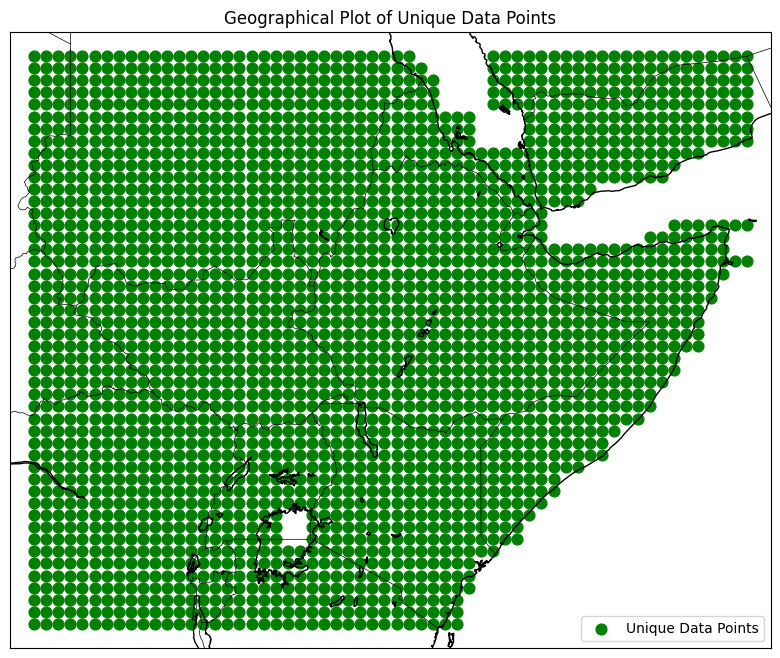

In [55]:
# Example usage:
# Assuming 'df' is your Polars DataFrame loaded with latitude and longitude data
plot_geographical_data(clean_df)

Latency in CERES they providing data with 3-4 months delay

In [56]:
import pygadm

gdf = pygadm.Items(name=["Rwanda", "Burundi", "Uganda", "Kenya", "Somalia", "Ethiopia", "Eritrea", "Djibouti"])
gdf

KeyboardInterrupt: 

In [ ]:
gdf.to_file("/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/countries.geojson", driver='GeoJSON')

In [ ]:
gdf = gpd.read_file("/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/01_raw/countries.geojson")

In [18]:
import polars as pl
import geopandas as gpd
from shapely.geometry import Point

def filter_dataframe_by_country(df, gdf):
    """
    Filters a Polars DataFrame based on country polygons.

    Parameters:
    - df (pl.DataFrame): Input Polars DataFrame with 'lat' and 'lon' columns.
    - gdf (gpd.GeoDataFrame): GeoDataFrame with country polygons.

    Returns:
    - pl.DataFrame: Filtered DataFrame with entries only within specified countries.
    """
    # Ensure gdf has a defined CRS
    if gdf.crs is None:
        gdf.set_crs("EPSG:4326", inplace=True)
    elif gdf.crs.to_string() != 'EPSG:4326':
        gdf = gdf.to_crs("EPSG:4326")

    # Convert Polars DataFrame to Pandas DataFrame to create GeoDataFrame
    unique_coords = df.select(['lat', 'lon']).unique().to_pandas()
    points_gdf = gpd.GeoDataFrame(unique_coords, geometry=[Point(xy) for xy in zip(unique_coords['lon'], unique_coords['lat'])], crs="EPSG:4326")

    # Spatial join to find points within the country polygons
    valid_points = gpd.sjoin(points_gdf, gdf, how="inner", predicate='intersects')
    valid_points_df = pl.from_pandas(valid_points[['lat', 'lon']])
    
    # Filter original DataFrame
    filtered_df = df.join(valid_points_df, on=['lat', 'lon'], how='semi')

    return filtered_df

# Example usage assuming 'clean_df' is your Polars DataFrame and 'gdf' is loaded using pygadm.Items
filtered_df = filter_dataframe_by_country(clean_df, gdf)


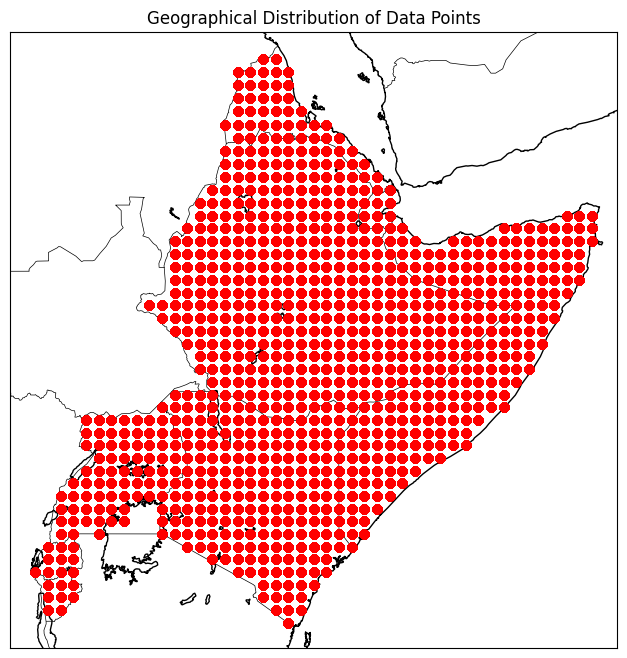

In [19]:
visualize_regions_polars(filtered_df)

In [25]:
filtered_df

time,lat,lon,PRECTOTCORR,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,CLOUD_AMT,ALLSKY_SFC_SW_DWN
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2001-01-01 00:00:00,-4.5,39.0,0.00001,28.270312,299.507812,300.459375,97890.3125,3.1796875,4.328125,0.015601,73.1,0.5484375,0.575,0.51875,46.671875,253.414062
2001-01-01 00:00:00,-4.0,29.5,0.000039,68.664062,295.8375,296.221875,87611.325,0.91875,1.3640625,0.0140625,72.0375,0.8203125,0.821875,0.8390625,93.84375,193.671875
2001-01-01 00:00:00,-4.0,30.0,0.000063,51.226562,293.84375,293.578125,85654.125,0.15625,0.8203125,0.013672,78.4375,0.7578125,0.765625,0.7890625,93.867188,197.355469
2001-01-01 00:00:00,-4.0,38.5,0.00001,6.78125,298.535937,300.082812,94193.65,3.0640625,4.3265625,0.013721,67.4375,0.534375,0.5625,0.478125,44.941406,242.082031
2001-01-01 00:00:00,-4.0,39.0,0.000006,6.60625,299.479688,301.001562,96774.2,3.2671875,4.5953125,0.014575,68.9125,0.49375,0.525,0.4375,45.03125,243.742188
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-01-01 00:00:00,17.0,38.0,0.000017,0.8125,295.495313,297.910937,91093.9,1.75625,2.375,0.011987,69.075,0.3953125,0.4015625,0.3578125,22.953125,183.226562
2024-01-01 00:00:00,17.0,38.5,0.000033,1.15,295.746875,297.707812,93069.375,1.934375,2.5296875,0.013696,76.3625,0.4359375,0.4390625,0.425,41.199219,150.332031
2024-01-01 00:00:00,17.0,39.0,0.000037,1.103125,297.9625,299.367188,97604.85,2.16875,2.6328125,0.015527,77.6625,0.4640625,0.4640625,0.621875,46.833984,150.035156


In [20]:
# Save the DataFrame with compression
filtered_df.write_parquet("/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/02_intermediate/preprocessed_power_nasa_data.parquet", compression="snappy")

In [ ]:
# # Create unique indices for each country if not already unique
# gdf['country_index'] = range(len(gdf))

# countries_mask = regionmask.Regions(
#     outlines=gdf['geometry'].values,
#     names=gdf['NAME_0'].values,
#     numbers=gdf['country_index'].values,  # Use the new unique index
#     abbrevs=gdf['GID_0'].values
# )

# # Generate the mask
# mask = countries_mask.mask(ds['lon'], ds['lat'], wrap_lon=True)

# # Apply the mask to the dataset
# masked_dataset = ds.where(mask.notnull())

In [1]:
# import polars as pl
# import pandas as pd
# import xarray as xr

# # Assuming 'filtered_df' is your initial Polars DataFrame
# pdf = filtered_df.to_pandas()

In [2]:
# pdf.head()

In [3]:
# # Sort and set MultiIndex without filling every possible combination
# pdf.sort_values(['time', 'lat', 'lon'], inplace=True)
# pdf.set_index(['time', 'lat', 'lon'], inplace=True)


In [4]:
# pdf

In [5]:
# Convert the DataFrame to xarray
# ds = pdf.to_xarray()

In [6]:
# ds

In [7]:
# # Define compression settings
# compression_opts = {'zlib': True, 'complevel': 5}  # You can adjust the compression level from 1 to 9

# # Apply the compression to each variable in the dataset
# encoding = {var: compression_opts for var in ds_filtered.variables}

# # Export the region as a compressed NetCDF4 file
# ds_filtered.to_netcdf(
#     path=os.path.join("/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/02_intermediate/preprocessed_power_nasa_data.nc"),
#     encoding=encoding
# )
